In [2]:
import tweepy

# Word frequency function
import pandas as pd
from collections import Counter

# Sentiment analysis function
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt

# Tweet cleaning function
import string
# Download the stopwords corpus
# from nltk import download
# download('stopwords')
from nltk.corpus import stopwords

public_key = "9s6eo2ApHmfCJJLq7l3hksY0W" 
secret_key = "N5fXK2juNCaXcjfarmJJklTDApDyVaj3tdi0fZkQEUuTVKigfD"
access_token = "2753152505-OKmaFkltJqNTCGCndXsgYRsSkbnhwnh3zppyhaf"
secret_token = "8A334mdKaSsmgegiYvHSPdAQ01Nmwj9RI9h3kiWX2zAjL"

auth = tweepy.OAuthHandler(public_key, secret_key)
auth.set_access_token(access_token, secret_token)
api = tweepy.API(auth)

C:\Users\VICTOR\Anaconda3\lib\site-packages\nltk\twitter\__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [5]:
def get_tweets_text(keyword, n_tweets, max_iter = None, display_progress=False):
    """Wrapper for tweepy search wrapper, allowing to get more tweets than the 100 limit
    Only returns the text from the tweets, which is the only thing needed. All the rest is left-out.
    Manages issues where the API would return duplicates"""

    try:
        if not max_iter:
            max_iter = n_tweets / 10 # API limitation (450 requests / 15 min)
        ser_texts = pd.Series(name = "Text")
        # Step 1: Fetches 100 tweets (max authorized by the API)
        src = api.search(keyword, count=100, lang="en", tweet_mode='extended')
        # Step 2: Retrieves the lowest ID to be reused in further queries as threshold
        min_id = min([tweet.id for tweet in src])  
        # Step 3: Creates a pd.Series with each row being a unique text from the tweets (uniqueness achieved with set())
        #         Only keeps the text of the tweet, rest of the information is lost
        tweets_txt = pd.Series(list(set([t.full_text for t in src])))
        # Step 4: Appends the texts to the resulting pd.Series
        ser_texts = ser_texts.append(tweets_txt, ignore_index = True)
        if display_progress:
            print(len(tweets_txt),"unique tweets found", "\nTotal tweets:", len(ser_texts))

        errs = 0 
        n_iter = 0 
        while len(ser_texts) < n_tweets and n_iter < max_iter: 
            # Same 4 steps
            new_src = api.search(keyword, count=100, lang="en", tweet_mode='extended', max_id=min_id-1)
            tweets_txt = pd.Series(list(set([t.full_text for t in new_src if t.full_text not in ser_texts.unique()])))
            ser_texts = ser_texts.append(tweets_txt, ignore_index = True)

            src = src + new_src
            # min_id sometimes can't be recovered for some reason -> if it happens too much, stop the loop
            try:
                min_id = min([tweet.id for tweet in src])
            except Exception as e:
                print("Failed to recover min_id")
                print(e)
                errs += 1
                if errs == 5:
                    break
                else:
                    continue
            if display_progress:
                print("Iteration", n_iter, "-",len(tweets_txt),"unique tweets found", "\nTotal tweets:", len(ser_texts))
            n_iter += 1
    except Exception as e:
        print(e)
    finally:
        return ser_texts[:n_tweets]


def clean_tweet(tweet):
    """Function for cleaning a tweet, removing trailing signs & stop words"""
    stop_words = set(stopwords.words('english')) # Defining the stopwords
    words_filtered = [word.lower() for word in tweet.split() if len(word) >= 3] # Keeping lengthy words only
    words_cleaned = [word for word in words_filtered
        if 'http' not in word
        and not word.startswith('@')
        and not word.startswith('#')
        and word != 'RT'] # A few pre-cleaning steps
    nostopwords = [word for word in words_cleaned if word not in stop_words] # Remove words qualified as stopwords
    sentence = " ".join(nostopwords) # Join the list of words into a sentence
    trans_tab = str.maketrans("","",string.punctuation+"\n") # A translation table mapping punctuation to None
    sentence = sentence.translate(trans_tab) # Remove punctuation using the translation table predefined
    return sentence
    
    
#### Fetching tweets, looping over each to score them
def sentiment_analysis(tweets):
    """Performs sentiment analysis on each tweet fed and aggregates the results
    Also plots positive tweets vs. negative ones"""
    sid = SentimentIntensityAnalyzer()
    count = 0
    pos = 0
    neg = 0
    neu = 0
    rest = 0
    for tweet in tweets:
        raw_txt = clean_tweet(tweet)
        ss = sid.polarity_scores(raw_txt)
        count += 1
        if ss["neg"] > ss["pos"] and ss["neg"] >= 0.3:
            neg += 1
        elif ss["pos"] > ss["neg"] and ss["pos"] >= 0.3:
            pos += 1
        elif ss["neu"] == 1:
            neu += 1
        else:
            rest += 1  
    
    print("Number of tweets studied: ", count)
    print("Number of duplicates (sanity check):", tweets.duplicated().sum())
    print("Percentage of positive tweets: ", round((pos/count)*100, 2), "%")
    print("Percentage of negative tweets: ", round((neg/count)*100, 2), "%")
    
    plt.bar(["Positive", "Negative"], [pos, neg], color = ['g', 'r'])
    return ({"Count" : count, "pos" : pos, "neg" : neg, "neut" : neu, "Uncertain" : rest})
   
    
def plot_frequent_words(tweets, exclude=None, n_words=10):
    """Counts the occurence of each word in all the tweets, and plot it"""
    # For each tweet in the pd.Series, cleans it and add left-over words to words
    words = []
    for tweet in tweets:
        raw_txt = clean_tweet(tweet).split(" ")
        words.extend(raw_txt)
    counter = Counter(words) # Dict mapping each word with number of occurences in words
    
    if exclude: # Enables leaving out specific keywords, such as the one used for the search
        if type(exclude) == list:
            for w in exclude:
                counter[w] = None
        else:
            counter[exclude] = None 
    
    # Turns the counter dict into a dataframe for easier plotting
    df = pd.DataFrame(data={"Words": list(counter.keys()), "Count":list(counter.values())}).sort_values("Count", ascending=False)
    # Plots n_to_plot most frequent words as a bar chart
    return df.iloc[:n_words,].plot(kind="bar", x="Words", y="Count")

[{'message': 'Rate limit exceeded', 'code': 88}]
Number of tweets studied:  9393
Number of duplicates (sanity check): 0
Percentage of positive tweets:  28.18 %
Percentage of negative tweets:  6.46 %


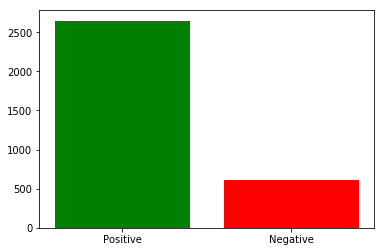

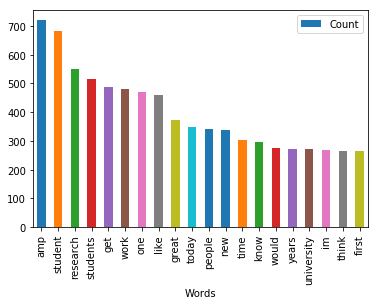

In [6]:
tweets = get_tweets_text(keyword="brexit", n_tweets=1000)
result_sent_analysis = sentiment_analysis(tweets)
ax_freq_words = plot_frequent_words(tweets, exclude=["brexit"], n_words=20)